> Texto fornecido sob a Creative Commons Attribution license, CC-BY. Todo o código está disponível sob a FSF-approved BSD-3 license.<br>
> (c) Original por Lorena A. Barba, Gilbert F. Forsyth em 2017, traduzido por Felipe N. Schuch em 2020.<br>
> [@LorenaABarba](https://twitter.com/LorenaABarba) - [@fschuch](https://twitter.com/fschuch)

12 passos para Navier–Stokes
======
***

Olá! Bem-vindo aos **12 passos para Navier-Stokes**. Esse é um módulo prático usado inicialmente como um curso interativo de Dinâmica dos Fluidos Computacional (CFD, do Inglês *Computational Fluid Dynamics*), ministrado pela [Prof. Lorena Barba](http://lorenabarba.com) desde a primavera de 2009 na Universidade de Boston. O curso assume que o leitor tenha conhecimentos básicos sobre programação (em qualquer linguagem) e alguma familiaridade com equações diferenciais e mecânica dos fluidos. Os "passos" foram inspirados pelas ideias do Dr. Rio Yokota, que era um pós-doc no laboratório da Prof. Barba. As lições foram refinadas pela Professora e seus estudantes ao longo de vários semestres. O curso é ensinado inteiramente em Python, e os alunos que não conhecem Python tem a oportunidade de aprender conforme progredimos pelas lições. Adaptado e traduzido para português por [Felipe N. Schuch](https://fschuch.github.io/).

Esse  [Jupyter notebook](https://jupyter-notebook.readthedocs.io/en/stable/) vai lhe guiar através do primeiro passo para programar sua própria ferramenta de resolução de Navier-Stokes em Python. Colocamos a mão na massa agora mesmo. Não se preocupe se inicialmente não entender tudo que está acontecendo, cobriremos cada detalhe à medida que avançamos, além disso, material complementar para o aprendizado está disponível em vídeo (em inglês) em [Prof. Barba's lectures on YouTube](http://www.youtube.com/playlist?list=PL30F4C5ABCE62CB61).

Para obter melhores resultados, uma vez concluido esse notebook, escreva seu próprio código para o Passo 1, seja em um script Python ou em um novo Jupyter notebook.

Passo 1: Convecção Linear Unidimensional
-----
***

O equação de Convecção Linear 1D é a versão mais simplificada, o modelo mais básico que se pode empregar para aprender algo sobre CFD. É supreendente o quanto essa pequena equação é capaz de nos ensinar! Aqui está ela:

$$\frac{\partial u(x,t)}{\partial t} + c \frac{\partial u(x,t)}{\partial x} = 0$$

Para uma dada condição inicial (denominada como *onda*), a equação descreve a propagação dessa *onda* inicial com uma velocidade $c$, sem mudar seu formato. Considerando a condição inicial como $u(x,0)=u_0(x)$, então a solução exata da equação é dada por $u(x,t)=u_0(x-ct)$.

Usamos o métodos das diferenças finitas para discretizar a equação no tempo e no espaço, usando um esquema de diferença para frente para a derivada temporal e um esquema de diferença para trás para a derivada espacial. Assim, se discretiza a coordenada espacial $x$ em pontos com índice $i$, sendo $0 \le i \le N$, e discretizamos o tempo em $n$ passos discretos de tamanho $\Delta t$.

À partir da definição de uma derivada (e simplesmente removendo o limite), sabemos que:

$$\frac{\partial u}{\partial x}\approx \frac{u(x+\Delta x)-u(x)}{\Delta x}$$

Nossa equação discreta é, então, dada por:

$$\frac{u_i^{n+1}-u_i^n}{\Delta t} + c \frac{u_i^n - u_{i-1}^n}{\Delta x} = 0 $$

Onde $n$ e $n+1$ são dois passos consecutivos no tempo, enquanto $i-1$ e $i$ são dois pontos vizinhos na discretização da coordenada $x$. Se a condição inicial é conhecida, então a única incógnita na discretização é $u_i^{n+1}$. Podemos isolar nossa incógnita para obter uma equação que nos permita avançar no tempo, que é escrita como:

$$u_i^{n+1} = u_i^n - c \frac{\Delta t}{\Delta x}(u_i^n-u_{i-1}^n)$$

Agora, é hora de implementá-la em Python. 

Vamos começar importando algumas bibliotecas que nos serão úteis:

* `numpy` é uma biblioteca que fornece uma série de ferramentas para manipulação matricial, similar ao MATLAB;
* `matplotlib` é uma biblioteca para produção gráfica 2D, usaremos para mostrar os resultados;
* `time` e `sys` proporcionam utilidades básicas de tempo e sistema, que usaremos para reduzir a velocidade da visualização de animações.

In [1]:
#Lembrete: comentários em Python são indicados pelo jogo da velha
import numpy                       #Aqui carregamos numpy
from matplotlib import pyplot      #Aqui carregamos matplotlib
import time, sys                   #E carregamos algumas utilidades

In [2]:
#isso faz os gráficos matplotlib aparecerem no notebook (em vez de em uma nova janela)
%matplotlib inline                  

Agora vamos definir alguns parâmetros. Queremos criar um domínio espacial com pontos igualmente espaçados e duas unidades de comprimento, isso é, $x_i\in(0,2)$. Para tanto, a função [numpy.linspace](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html) é exatamente o que precisamos.

In [3]:
#Tente mudar esse número de 41 para 81
#então execute tudo (Run All).
#O que acontece?
x = numpy.linspace(0., 2., num = 41)

nt = 25    #Número de passos de tempo que queremos calcular
dt = .025  #Tamanho de cada passo de tempo
c = 1      #Velocidade de propagação da onda

É sempre possível acessar a documentação de uma dada função se você quiser saber mais detalhes. Tente executar uma célular com o comando:
```python
help(numpy.linspace)
```

À partir de `x`, extraímos o parâmetro `nx` como o número de pontos na malha e `dx` será o espaçamento entre eles. 

In [4]:
nx = x.size
dx = x[1] - x[0]

Também precisamos definir a condição inicial (CI). Digamos que a velocidade inicial $u_0$ é dada por $u_0 = 2$ no intervalo $0,5 \leq x \leq 1$, senão $u_0 = 1$ (isso é, uma função chapéu).

Aqui, utilizamos a função [numpy.ones_like](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ones_like.html), onde `u` terá o mesmo formato de `x`, porém o valor em todos os elementos será 1.

In [5]:
u = numpy.ones_like(x)   #Função ones_like do numpy
u[(0.5<=x) & (x<=1)] = 2 #Define u = 2 entre 0,5 e 1,
                         #de acordo com nossa CI

print(u)                 #Verificamos o resultado na tela

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


**Nota:** perceba que nesse contexto, tanto `numpy.ones_like(x)` quanto `numpy.ones(nx)` produzem o mesmo resultado. Experimente!

Vamos visualizar essa condição inicial representando-a graficamente com [Matplotlib](https://matplotlib.org/). Nós já importamos o pacote gráfico `pyplot` da biblioteca `matplotlib`, agora vamos usar a função chamada `plot`, ao invocar `pyplot.plot`. Para saber mais sobre toda a capacidade de Matplotlib, explore a [Galeria de exemplos](http://matplotlib.org/gallery.html).

Aqui, nós usamos a sintaxe simples para gráficos bidimensionais `plot(x,y)`:

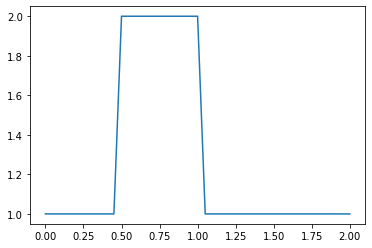

In [6]:
pyplot.plot(x, u);

Por que a função chapéu (*hat function*) não apresenta linhas perfeitamente retas? Pense sobre isso.

Agora é o momento de implementar a equação de convecção discretizada pelos esquemas de diferenças finitas.

Para cada elemento do nosso arranjo `u`, nós precisamos realizar a operação $u_i^{n+1} = u_i^n - c \frac{\Delta t}{\Delta x}(u_i^n-u_{i-1}^n)$.

Vamos armazenar o resultado em um novo (temporário) arranjo `un`, que será a solução $u$ para o passo de tempo seguinte. Repetiremos essa operação por tantos passos de tempo quando especificamos anteriormente, e então poderemos ver o quão longe a onda se moveu por convecção.

Começamos inicializando o arranjo auxiliar `un` para mantermos os valores que calculamos para o passo de tempo $n+1$, novamente utilizando a função NumPy `ones_like()`.  

Finalmente, podemos pensar que temos duas operações iterativas: uma no tempo e uma no espaço (veremos uma abordagem diferente mais tarde). Então, começamos pelo aninhamento um laço dentro de outro. Note que usamos a elegante função `range()`. Quando escrevemos `for i in range(1,nx)`, nós vamos interar através do arranjo `u`, mas vamos pular o primeiro elemento (0 elemento zero). *Por quê?*

In [7]:
un = numpy.ones_like(u) #Inicializar o arranjo temporário

for n in range(nt): #Laço para os valores de 0 a nt-1, então será executado nt vezes 
    un = u.copy()   ##Cópia dos valores de u para un
    for i in range(1, nx): ##Você pode tentar comentar essa linha...
    #for i in range(nx): ## ... e descomentar essa linha, para ver o que acontece!
        u[i] = un[i] - c * dt / dx * (un[i] - un[i-1])

**Nota:** Vamos aprender mais tarde que o código escrito acima é bastante ineficiente, e que existem melhores maneiras para escreve-lo ao estilo Python. Porém, vamos continuar.

Agora, vamos graficar nosso arranjo `u` após o avanço no tempo.

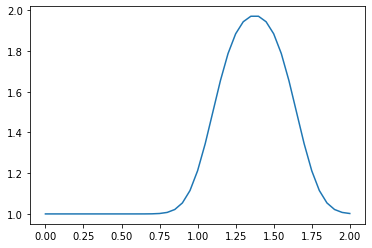

In [8]:
pyplot.plot(x, u);

Certo! Então nossa função chapéu definitivamente se moveu para a direita, entretanto, ela não se parece mais com um chapéu. **O que aconteceu?**

Material Complementar
-----
***

Para uma explicação mais detalhada sobre o método de diferenças finitas, incluindo assuntos como erro de truncamento, ordem de convergência e outros detalhes, assista (EN) **Video Lessons 2 and 3** por Prof. Barba no YouTube.

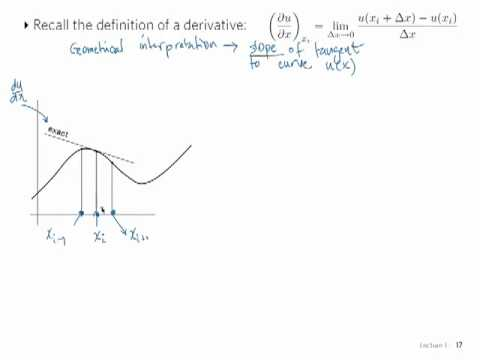

In [9]:
from IPython.display import YouTubeVideo
YouTubeVideo('iz22_37mMkk')

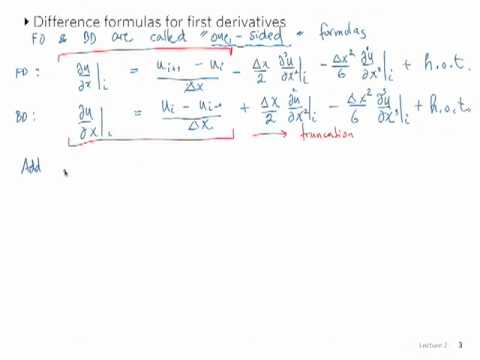

In [10]:
YouTubeVideo('xq9YTcv-fQg')

Para uma explicação passo à passo sobre a discretização da equaçaõ de convecção linear com diferenças finitas (e também os passos seguintes, até o Passo 4), assista **Video Lesson 4** por Prof. Barba no YouTube.

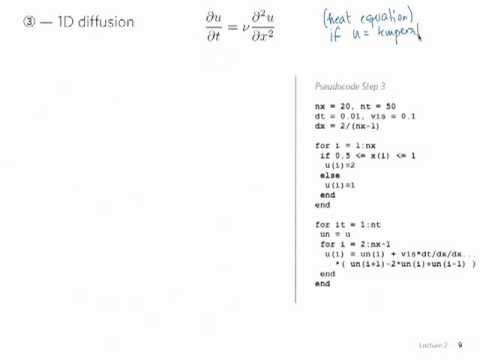

In [11]:
YouTubeVideo('y2WaK7_iMRI')

## Por último, mas não menos importante

**Lembre-se** de reescrever o Passo 1 como um novo script Python, ou seu próprio Jupyter notebook e então experimente mudar os parâmetros de discretização. Uma vez feito isso, você pode prosseguir para o [Passo 2](./02_Passo_2.ipynb).

***

In [12]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

> A célula acima executa o estilo para esse notebook. Nós modificamos o estilo encontrado no GitHub de [CamDavidsonPilon](https://github.com/CamDavidsonPilon), [@Cmrn_DP](https://twitter.com/cmrn_dp).